<a href="https://colab.research.google.com/github/jfgf11/Examen-2-Machine/blob/master/examen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Examen 2




In [1]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Instalación

In [2]:
!pip install pyEDFlib
!pip install progressbar2

     |████████████████████████████████| 1.1MB 10.0MB/s 
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=920116 sha256=adddb3f50e9804a993f4ac6c9b038b04501921057deb37bcc9029423ea4fda18
  Stored in directory: /root/.cache/pip/wheels/57/e3/8e/ce6236e9ada08b8ff91ef922c7418dbd66f1182dfbb22f8579
Successfully built pyEDFlib


#Librerías

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
import pyedflib as pyedf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import progressbar

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import AdaBoostClassifier
import sklearn as sk
import itertools

#Clases

In [0]:
#Esta no esta terminada.
class Resultados:
    def __init__(self, p_y_pred, p_y_true):#, p_labels):
        self.y_pred = p_y_pred
        self.y_true = p_y_true
        #self.convertirClases()
        #self.labels = p_labels

    def convertirClases(self):
      self.y_pred_convertidos = ((self.y_pred == 1) + (self.y_pred == 2)) + 2*((self.y_pred == 3) + (self.y_pred == 4)) + 3*(self.y_pred == 5)
      self.y_true_convertidos = ((self.y_true == 1) + (self.y_true == 2)) + 2*((self.y_true == 3) + (self.y_true == 4)) + 3*(self.y_true == 5)

    def darMatrizConfusion(self):
      cm = confusion_matrix(self.y_true, self.y_pred)#, self.labels)
      print(cm)
      #Terminar esto
      #ax = plt.subplot()
      #sns.heatmap(cm, annot = True, ax = ax); #annot=True to annotate cells
      #return cm

    def calcularError(self):
      error = np.sum(self.y_pred_convertidos != self.y_true_convertidos)
      error = error/len(self.y_pred_convertidos)

      return error

      

#Lectura de los Datos

In [0]:
filenameDatos = "drive/My Drive/sleep-cassette"
filenameDescripcion = "drive/My Drive/SC-subjects.xls"

ArchivoLightsOff=pd.read_excel(filenameDescripcion, sheet_name='Blad1')

TiempoLightsOff=ArchivoLightsOff["LightsOff"].values
TiempoLightsOffSegundos=TiempoLightsOff
HorasSuenio=8

for i in range (0, len(TiempoLightsOff)):
  segundos=int(TiempoLightsOff[i].hour) * 3600 + int(TiempoLightsOff[i].minute) * 60
  TiempoLightsOffSegundos[i]=segundos

listaArchivos = os.listdir(filenameDatos)

listaHypnograms = [i for i in listaArchivos if "Hypnogram" in i] 
listaPSGs = [i for i in listaArchivos if "PSG" in i]

listaHypnograms.sort()
listaPSGs.sort()

print("Importando datos...")

start = time.time()

Datos1=np.zeros(3000)
Datos2=np.zeros(3000)
Datos3=np.zeros(3000)

Etiquetas=[0]

p = 0
inicioNumArchivos =10
numArchivos = 10

with progressbar.ProgressBar(max_value=numArchivos*960) as bar:
  for i in range(inicioNumArchivos,inicioNumArchivos+numArchivos):#len(listaHypnograms)):

    hyp = listaHypnograms[i]
    psg = listaPSGs[i]

    print("Hyp: {}, PSG: {}".format(hyp,psg))

    fileHyp = pyedf.EdfReader(filenameDatos + "/" + hyp)
    filePSG = pyedf.EdfReader(filenameDatos + "/" + psg)

    hypTime, hypDur, hypEtiqueta = fileHyp.readAnnotations()

    tiempoComienzo = fileHyp.starttime_hour*3600+fileHyp.starttime_minute*60+fileHyp.starttime_second
    offset=TiempoLightsOffSegundos[i]-tiempoComienzo
    if offset<0:
      offset+=24*3600
    LimiteSuperior=offset+HorasSuenio*3600
    ventana=30
    tiempo=offset
    j=0
    referenciaSenial=0
    FrecuenciaMuestreo = filePSG.getSampleFrequency(referenciaSenial)

    while tiempo<LimiteSuperior:
      if tiempo>hypTime[j]:
        j+=1
        
      ventanaMuestra = np.round(FrecuenciaMuestreo * ventana)
      muestraInicial = np.round(FrecuenciaMuestreo * tiempo)
      senial1=filePSG.readSignal(0)
      senial2=filePSG.readSignal(1)
      senial3=filePSG.readSignal(2)
      senialActual1=senial1[muestraInicial:muestraInicial+ventanaMuestra]
      senialActual2=senial2[muestraInicial:muestraInicial+ventanaMuestra]
      senialActual3=senial3[muestraInicial:muestraInicial+ventanaMuestra]
      
      etiquetaActual=hypEtiqueta[j]
      
      Datos1=np.vstack((Datos1,senialActual1))
      Datos2=np.vstack((Datos2,senialActual2))
      Datos3=np.vstack((Datos3,senialActual3))

      Etiquetas=np.vstack((Etiquetas,etiquetaActual))
      tiempo+=ventana
      p+=1
      bar.update(p)

    fileHyp._close() 
    filePSG._close()
#print(listaHypnograms)
#print(listaPSGs)

print("Termino.")
print("Tiempo: {} segundos.".format(time.time()-start))

In [0]:
def appendDatos(pDatos1, pDatos2, pDatos3):
  Datos_Generales=np.zeros((pDatos1.shape[0],3000,3))

  for i in progressbar.progressbar(range(0,pDatos1.shape[0])):

    Datos_Generales[i,:,0]=pDatos1[i]
    Datos_Generales[i,:,1]=pDatos2[i]
    Datos_Generales[i,:,2]=pDatos3[i]
    
  return Datos_Generales


In [0]:
test = appendDatos(Datos1, Datos2, Datos3)

(3, 3000, 8864)

In [0]:
#filePSG = pyedf.EdfReader(filenameDatos + "/" + psg)
#filePSG._close()
filenameDatos + "/" + psg

'drive/My Drive/sleep-cassette/SC4002E0-PSG.edf'

In [0]:
#Esto solo se corre una vez.
Etiquetas = Etiquetas[1:len(Etiquetas)]
Datos = Datos[1:Datos.shape[0]]

In [0]:
numArchivos = 10
def eliminarClaseDesconocida(pDatos, pEtiquetas):
  et = []
  dat = np.zeros(3000)

  with progressbar.ProgressBar(max_value=numArchivos*960) as bar:
    for i in range(0, len(pEtiquetas)):
      bar.update(i)
      if pEtiquetas[i] != 'Sleep stage ?':
        
        if pEtiquetas[i]=="Sleep stage W":
          et = np.append(et,0)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 1":
          et = np.append(et,1)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 2":
          et = np.append(et,2)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 3":
          et = np.append(et,3)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage 4":
          et = np.append(et,4)
          dat = np.vstack((dat, pDatos[i,:]))
        elif pEtiquetas[i]=="Sleep stage R":
          et = np.append(et,5)
          dat = np.vstack((dat, pDatos[i,:]))
        else:
          pass
          #print("Hay una clase distinta a las definidas.")

  dat = dat[1:dat.shape[0]]
  return dat, et

#Datos1, Etiquetas = eliminarClaseDesconocida(unosDatos, unosEtiquetas)
#np.save("Datos", unosDatos)
#np.save("Etiquetas", unosEtiquetas)

#print(len(unosEtiquetas))
#print(len(unosDatos))

#Entrenamiento del Modelo

In [0]:
#unosEtiquetas=np.load("drive/My Drive/Etiquetas.npy")
#unosDatos=np.load("drive/My Drive/Datos.npy")
#np.save("drive/My Drive/Datos1", Datos1)
#np.save("drive/My Drive/Etiquetas", unosEtiquetas)
#np.save("drive/My Drive/Etiquetas", unosEtiquetas)
#Datos1 = np.load("drive/My Drive/Datos1.npy")
#Datos2 = np.load("drive/My Drive/Datos2.npy")
#Datos3 = np.load("drive/My Drive/Datos3.npy")

#Datos1, unosEtiquetas = eliminarClaseDesconocida(Datos1, unosEtiquetas)

#unosDatos = appendDatos(Datos1, Datos2, Datos3)
#np.save("drive/My Drive/DatosCompletos.npy", unosDatos)
unosDatos = np.load("drive/My Drive/DatosCompletos.npy")
unosEtiquetas=np.load("drive/My Drive/Etiquetas.npy")

In [8]:
unosEtiquetas.shape

(8864,)

In [10]:
unosDatos[1, :, :]

array([[ -24.70915751,  -11.87252747, -130.34456654],
       [ -23.67765568,   -7.64981685, -129.35897436],
       [ -22.64615385,  -11.39267399, -126.89499389],
       ...,
       [   5.01684982,    2.23516484,   17.0014652 ],
       [   5.67326007,   -3.61904762,    1.23199023],
       [  16.73846154,  -16.57509158,   -2.21758242]])

In [19]:
unosDatos[990,:,:]

array([[-15.33479853,   5.85934066,  -9.38705739],
       [-18.28791209,   5.46666667,  -1.18803419],
       [-16.45494505,   4.48498168,   0.74114774],
       ...,
       [ 24.99047619,   0.95091575, -40.73626374],
       [ 15.52014652,   1.83443223, -16.13919414],
       [ 22.95384615,  -0.81611722, -14.69230769]])

In [20]:
unosEtiquetas

array([1., 1., 1., ..., 1., 1., 2.])

In [0]:
#x_train, x_test, y_train, y_test = train_test_split(np.transpose(unosDatos), unosEtiquetas , random_state = 0, test_size=0.10)
#x_train = np.expand_dims(np.transpose(x_train), axis=3) # reshape (569, 30) to (569, 30, 1) 

print(x_train.shape)

(7977, 3000, 3)


#Implementación en Keras

Se separan los datos de entrenamiento y validación

In [0]:
x_train, x_test, y_train, y_test = train_test_split(unosDatos, unosEtiquetas , random_state = 0, test_size=0.10)
#x_train = np.expand_dims(np.transpose(x_train), axis=3) # reshape (569, 30) to (569, 30, 1) 
#x_test = np.expand_dims(np.transpose(x_test), axis=3) # reshape (569, 30) to (569, 30, 1) 

Creación del modelo

In [21]:
def crearModelo(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):
  #Numero de clases
  numClases = 6

  modelo = Sequential()

  #Esto corresponderia a la parte convolucional.
  #modelo.add(Conv1D(pNumFiltros[0], int(pTamFiltros[0]), activation = 'relu', input_shape = (3000,1)))
  modelo.add(Conv1D(pNumFiltros[0], int(pTamFiltros[0]), activation = 'relu', input_shape = (3000,3)))
  #modelo.add(MaxPooling1D(int(pTamPooling[0])))
  modelo.add(Conv1D(pNumFiltros[1], int(pTamFiltros[1]), activation = 'relu'))
  modelo.add(MaxPooling1D(int(pTamPooling[0])))
  modelo.add(Conv1D(pNumFiltros[2], int(pTamFiltros[2]), activation = 'relu'))
  modelo.add(Conv1D(pNumFiltros[3], int(pTamFiltros[3]), activation = 'relu'))
  #modelo.add(AveragePooling1D(int(pTamPooling[1])))
  #modelo.add(Conv1D(pNumFiltros[4], int(pTamFiltros[4]), activation = 'relu'))
  #modelo.add(Conv1D(pNumFiltros[5], int(pTamFiltros[5]), activation = 'relu'))
  modelo.add(GlobalAveragePooling1D())
  #modelo.add(GlobalMaxPooling1D())
  #modelo.add(MaxPooling1D(int(pTamPooling[2])))
  #modelo.add(Flatten())

  #Esto corresponderia a la parte de red neuronal normalita. (Puse cualquier cosa por ahora)
  #modelo.add(Dropout(0.5))
  #modelo.add(Dense(pNumNeuronas[0], activation = 'relu'))
  #modelo.add(Dropout(0.5))
  #modelo.add(Dense(pNumNeuronas[1], activation = 'relu'))#, activity_regularizer=l2(pAlpha)))
  #modelo.add(Dense(pNumNeuronas[2], activation = 'relu', activity_regularizer=l2(pAlpha)))
  modelo.add(Dense(numClases, activation = 'softmax'))#, activity_regularizer = l2(pAlpha)))

  sgd = optimizers.SGD(lr = pTasa, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  #modelo.summary()

  return modelo

modelo = crearModelo(tasa, alpha, numFiltros, tamFiltros, tamPooling ,numNeuronas, optimizer)
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 2991, 100)         3100      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2982, 100)         100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 994, 100)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 985, 160)          160160    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 976, 160)          256160    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [22]:
numFiltros = np.array([100, 100, 160, 160, 6, 6])
tamFiltros = np.array([10, 10, 10, 10, 6, 6])
tamPooling = np.array([3, 8, 6])
optimizer="sgd"
numNeuronas = np.array([30, 20, 10])

tasa = 0.001
alpha = 0.01

modelo = crearModelo(tasa, alpha, numFiltros, tamFiltros, tamPooling ,numNeuronas, optimizer)

epocas = 50
batchSize = 400
hist = modelo.fit(x_train, y_train, verbose = 1, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize)

graficarHistoria(hist)

resultadosEntrenamiento = Resultados(y_train, modelo.predict_classes(x_train))
resultadosValidacion = Resultados(y_test, modelo.predict_classes(x_test))

print(resultadosEntrenamiento.darMatrizConfusion())
print(resultadosValidacion.darMatrizConfusion())

Train on 7977 samples, validate on 887 samples
Epoch 1/50
7977/7977 [==============================] - 12s 1ms/sample - loss: 1.6926 - sparse_categorical_accuracy: 0.3397 - val_loss: 1.5786 - val_sparse_categorical_accuracy: 0.3788
Epoch 2/50
7977/7977 [==============================] - 12s 1ms/sample - loss: 1.5039 - sparse_categorical_accuracy: 0.4237 - val_loss: 1.5534 - val_sparse_categorical_accuracy: 0.3878
Epoch 3/50
7977/7977 [==============================] - 11s 1ms/sample - loss: 1.4673 - sparse_categorical_accuracy: 0.4337 - val_loss: 1.5329 - val_sparse_categorical_accuracy: 0.3901
Epoch 4/50
7977/7977 [==============================] - 11s 1ms/sample - loss: 1.4502 - sparse_categorical_accuracy: 0.4356 - val_loss: 1.5147 - val_sparse_categorical_accuracy: 0.3912
Epoch 5/50
7977/7977 [==============================] - 11s 1ms/sample - loss: 1.4392 - sparse_categorical_accuracy: 0.4349 - val_loss: 1.5099 - val_sparse_categorical_accuracy: 0.3980
Epoch 6/50
7977/7977 [======

NameError: ignored

In [0]:
modelo6Clases=modelo

In [0]:
numFiltros = np.array([100, 50, 20])
tamFiltros = np.array([6, 6, 6])
tamPooling = np.array([6, 6, 6])
optimizer="adam"
numNeuronas = np.array([10, 8, 6])

parametros = dict(batch_size = [30],
               epochs = [5],
               pOptimizer = ["adam", "sgd"],#,"rmsprop"],
               pTasa = [0.01],
               pAlphas = [0.001],
               pNumFiltros = [numFiltros],
              pTamFiltros = [tamFiltros],
              pTamPooling = [tamPooling],
              pNumNeuronas = [numNeuronas]
              )

In [0]:
def GridSearch(pXtrain, pYtrain, pXtest, pYtest, pParameters):
  i=0
  parameters = []
  bestScore = 0
  bestModel=None
  bestHist = None
  contador=0
  for k in parametros.keys():
    parameters.append(pParameters.get(k))
  with progressbar.ProgressBar(max_value=len(list(itertools.product(*parameters)))) as bar:
    for p in itertools.product(*parameters):
      contador=+1
      bar.update(contador)
      modelo=crearModelo(p[3],p[4],p[5],p[6],p[7],p[8], p[2])
      hist = modelo.fit(pXtrain, pYtrain, verbose = 1, validation_data=(pXtest, pYtest), epochs = p[1], batch_size = p[0])
      l, score =modelo.evaluate(pXtest,pYtest)
      if score>bestScore:
        bestScore = score
        bestModel = modelo
        bestHist = hist
  return bestScore, bestModel, bestHist

N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Train on 7977 samples, validate on 887 samples
Epoch 1/5
7977/7977 [==============================] - 3s 361us/sample - loss: 1.6520 - sparse_categorical_accuracy: 0.3236 - val_loss: 1.6377 - val_sparse_categorical_accuracy: 0.2954
Epoch 2/5
7977/7977 [==============================] - 2s 302us/sample - loss: 1.6042 - sparse_categorical_accuracy: 0.3412 - val_loss: 1.6478 - val_sparse_categorical_accuracy: 0.2954
Epoch 3/5
7977/7977 [==============================] - 2s 304us/sample - loss: 1.6057 - sparse_categorical_accuracy: 0.3421 - val_loss: 1.6405 - val_sparse_categorical_accuracy: 0.2954
Epoch 4/5
7977/7977 [==============================] - 2s 305us/sample - loss: 1.6134 - sparse_categorical_accuracy: 0.3273 - val_loss: 1.6373 - val_sparse_categorical_accuracy: 0.2954
Epoch 5/5
887/887 [==============================] - 0s 143us/sample - loss: 1.6402 - sparse_categorical_accuracy: 0.2954


 50% (1 of 2) |#############             | Elapsed Time: 0:00:13 ETA:   0:00:13

Train on 7977 samples, validate on 887 samples
Epoch 1/5
7977/7977 [==============================] - 3s 349us/sample - loss: 1.6346 - sparse_categorical_accuracy: 0.3383 - val_loss: 1.6308 - val_sparse_categorical_accuracy: 0.2965
Epoch 2/5
7977/7977 [==============================] - 2s 306us/sample - loss: 1.5496 - sparse_categorical_accuracy: 0.3894 - val_loss: 1.5556 - val_sparse_categorical_accuracy: 0.3901
Epoch 3/5
7977/7977 [==============================] - 2s 302us/sample - loss: 1.4849 - sparse_categorical_accuracy: 0.4159 - val_loss: 1.5129 - val_sparse_categorical_accuracy: 0.3890
Epoch 4/5
7977/7977 [==============================] - 2s 303us/sample - loss: 1.4540 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.4913 - val_sparse_categorical_accuracy: 0.4002
Epoch 5/5
887/887 [==============================] - 0s 144us/sample - loss: 1.4619 - sparse_categorical_accuracy: 0.4036


100% (2 of 2) |##########################| Elapsed Time: 0:00:27 Time:  0:00:27


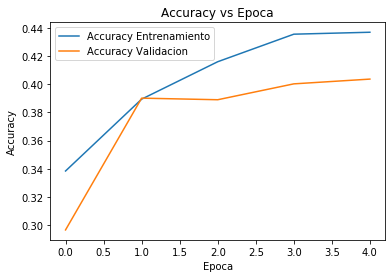

In [0]:
bestScore, bestModel, bestHist = GridSearch(x_train,y_train,x_test,y_test,parametros)
graficarHistoria(bestHist)

In [0]:
backUpEtiquetas = unosEtiquetas
def convertirClases(pY):
      y = ((pY == 1) + (pY == 2)) + 2*((pY == 3) + (pY == 4)) + 3*(pY == 5)

      return y

unosEtiquetas = convertirClases(unosEtiquetas)



In [0]:
print(backUpEtiquetas[10:50].astype(int))
print(unosEtiquetas[10:50])

[1 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 4 4 4 4 4 3 4 4 3 3 4 3 3 3 3 4
 0 0 0]
[1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 0 0]


#Resultados

In [0]:
def graficarHistoria(pHist):
  plt.plot(pHist.history['sparse_categorical_accuracy'], label = 'Accuracy Entrenamiento')
  plt.plot(pHist.history['val_sparse_categorical_accuracy'], label = 'Accuracy Validacion')
  plt.xlabel('Epoca')
  plt.ylabel('Accuracy')
  plt.title("Accuracy vs Epoca")
  plt.legend()
  plt.show()

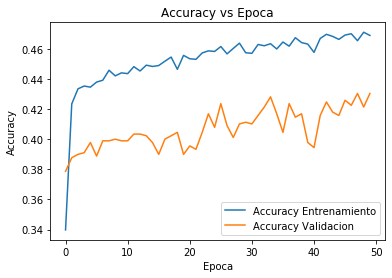

In [24]:
graficarHistoria(hist)

In [0]:
y1 = modelo.predict_classes(x_train)
y2 = modelo.predict_classes(x_test)

print(confusion_matrix(y_train, y1))
print(confusion_matrix(y_test, y2))

[[ 132  789   56   26]
 [   1 3736  229   20]
 [  10  527 1739   26]
 [   1  361    5  319]]
[[  6 104  14   4]
 [  3 346  60  14]
 [  0  87 153   4]
 [  0  72   5  15]]
